In [ ]:
!pip install numpy
import numpy as np

!pip install torch
import torch

!pip install sentence-transformers scikit-learn matplotlib
from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

!pip install pandas
import pandas as pd
!pip install seaborn
import seaborn as sns


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Load sentence-level transformer model

embedder = SentenceTransformer("intfloat/e5-small")


In [3]:
# Embeddings are L2-normalised, ensures consine-sim.

def embed(sentences):
    if isinstance(sentences, str):
        sentences = [sentences]
    return embedder.encode(
        sentences,
        normalize_embeddings=True
    )


In [15]:
# construct "past-aware" and "present" sentences

past_sentences = [
    "In previous decades, environmental conditions were markedly different from those observed today.",
    "Historical records show that ecosystems once functioned under very different conditions.",
    "Past generations experienced environmental conditions that no longer exist today.",
    "Long-term environmental change has altered ecosystems compared to their historical states.",
    "Environmental baselines from earlier periods reveal substantial declines over time.",
    "Historically, natural systems were more stable and abundant than they are now.",
    "Comparisons with historical environmental conditions highlight significant long-term change.",
    "Looking at past environmental baselines reveals how much has been lost over time."
]


present_sentences = [
    "Environmental conditions are primarily discussed in terms of how they appear today.",
    "Current environmental conditions are treated as the normal point of reference.",
    "Discussions of the environment tend to focus on present-day conditions without historical comparison.",
    "Environmental assessments often rely on current observations alone.",
    "The environment is typically evaluated based on contemporary conditions.",
    "Present-day environmental conditions shape how environmental problems are understood.",
    "Environmental discourse frequently centers on what is observable in the present.",
    "Current conditions are often assumed to represent the natural state of the environment."
]


In [16]:
# Compute centroids = average semantic meaning

past_embeddings = embed(past_sentences)
present_embeddings = embed(present_sentences)

# Creating temporal concept vector
temporal_vector = past_embeddings.mean(axis=0) - present_embeddings.mean(axis=0)
temporal_vector = temporal_vector / np.linalg.norm(temporal_vector)


In [17]:
# Projecting env domains onto the temporal axis

domain_sentences = {
    "Atmosphere": [
        "The atmosphere consists of layers of gases surrounding the Earth.",
        "Atmospheric processes influence weather and climate systems.",
        "The atmosphere plays a central role in regulating temperature and precipitation."
    ],

    "Biodiversity": [
        "Biodiversity refers to the variety of life forms within ecosystems.",
        "Biological diversity includes variation within and between species.",
        "Biodiversity is an important component of ecosystem functioning."
    ],

    "Forests": [
        "Forests are ecosystems dominated by trees and woody vegetation.",
        "Forest systems support ecological, economic, and social functions.",
        "Forests play a role in carbon storage and habitat provision."
    ],

    "Oceans": [
        "Oceans cover a large portion of the Earth's surface.",
        "Marine ecosystems support diverse biological and physical processes.",
        "Oceans influence global climate and biogeochemical cycles."
    ]
}



domain_embeddings = {
    name: embed(sentence)[0]
    for name, sentence in domain_sentences.items()
}


In [18]:
# Measure temporal alignment by cosine similarity

scores = {
    name: cosine_similarity(
        domain_embeddings[name].reshape(1, -1),
        temporal_vector.reshape(1, -1)
    )[0][0]
    for name in domain_embeddings
}

scores


{'Atmosphere': np.float32(-0.05764122),
 'Biodiversity': np.float32(-0.013637113),
 'Forests': np.float32(-0.006642941),
 'Oceans': np.float32(-0.044634923)}

In [19]:
labels = ["Temporal Vector"] + list(domain_embeddings.keys())
vectors = np.vstack(
    [temporal_vector] +
    [domain_embeddings[k] for k in domain_embeddings]
)

# pca to reduce dimensionality 

pca = PCA(n_components=2)
proj = pca.fit_transform(vectors)


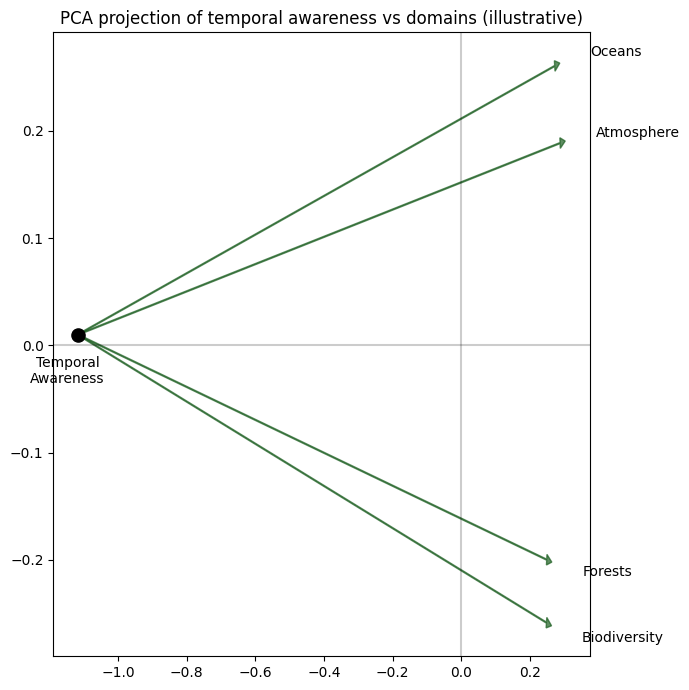

In [20]:
plt.figure(figsize=(7, 7))

# Color
temporal_color = "black"   
domain_color = "black"     
arrow_color = "#1b5e20"      
refline_color = "black"     
title_color = "black"     


origin = proj[0]  # temporal vector

label_offset = 0.06
right_bias = 0.03

for i, label in enumerate(labels[1:], start=1):
    dx = proj[i][0] - origin[0]
    dy = proj[i][1] - origin[1]

    # arrows (domains)
    plt.arrow(
        origin[0], origin[1],
        dx, dy,
        head_width=0.01,
        length_includes_head=True,
        alpha=0.7,
        color=arrow_color
    )

    # normalize direction
    norm = np.sqrt(dx**2 + dy**2)
    ux, uy = dx / norm, dy / norm

    # domain labels
    plt.text(
        proj[i][0] + ux * label_offset + right_bias,
        proj[i][1] + uy * label_offset,
        label,
        ha="left",
        va="center",
        color=domain_color
    )

# temporal vector point
plt.scatter(
    origin[0],
    origin[1],
    s=90,
    color=temporal_color
)

# temporal vector label
x_left = -0.03
y_down = -0.02

plt.text(
    origin[0] + x_left,
    origin[1] + y_down,
    "Temporal\nAwareness",
    ha="center",
    va="top",
    color=temporal_color
)

# reference lines
plt.axhline(0, alpha=0.2, color=refline_color)
plt.axvline(0, alpha=0.2, color=refline_color)

# title
plt.title(
    "PCA projection of temporal awareness vs domains (illustrative)",
    color=title_color
)

plt.tight_layout()
plt.show()


In [21]:
df = pd.DataFrame.from_dict(
    scores,
    orient="index",
    columns=["Temporal alignment"]
)


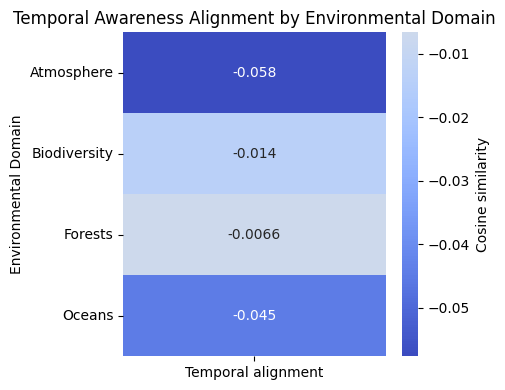

In [22]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    df,
    annot=True,
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Cosine similarity"}
)
plt.title("Temporal Awareness Alignment by Environmental Domain")
plt.ylabel("Environmental Domain")
plt.xlabel("")
plt.tight_layout()
plt.show()


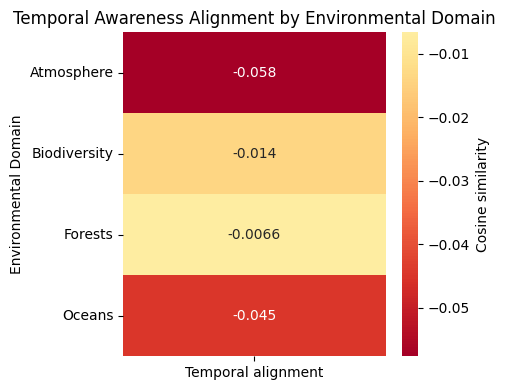

In [23]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    df,
    annot=True,
    cmap="RdYlGn",   # red → yellow → green
    center=0,
    cbar_kws={"label": "Cosine similarity"}
)
plt.title("Temporal Awareness Alignment by Environmental Domain")
plt.ylabel("Environmental Domain")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [25]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    df,
    annot=True,
    cmap="dark_greens",   # from the previous step
    center=0,
    vmin=-0.5,          # widen lower bound
    vmax=0.5,           # widen upper bound
    cbar_kws={"label": "Cosine similarity"}
)
plt.title("Temporal Awareness Alignment by Environmental Domain")
plt.ylabel("Environmental Domain")
plt.xlabel("")
plt.tight_layout()
plt.show()




KeyError: "'dark_greens' is not a known colormap name"

<Figure size 500x400 with 0 Axes>